# Portfolio Optimization

This analysis explores a typical portfolio optimization problem using two approaches:

- Analytical Method: Efficient Frontier via Markowitz's mean-variance optimization.
- Simulation-Based Method: Monte Carlo simulations to visualize the risk-return trade-off.
The second part focuses on simulations to illustrate the concept and benefits of diversification.

#### Brief Guide to the Notebook

Data is either downloaded directly from Yahoo Finance or generated through simulations, so no CSV files are required. The theory is briefly introduced each time, making the notebook self-contained and easy to follow. Users can modify key parameters to explore different scenarios. The notebook should be run sequentially; using "Run All" is recommended to ensure consistency in results.  

### Data Selection

To calculate returns for the efficient frontier, we require multiple periods of historical data. Downloading only the most recent prices from Yahoo Finance would yield a single price snapshot, preventing the calculation of returns and standard deviation.  

Since the composition of the Dow Jones Industrial Average (DJIA) changes over time, we focus on the most recent stable period with no composition changes: August 31, 2020 – February 26, 2024. This selection ensures more realistic and reliable estimates of returns and risk.  

The selected 30 stocks are:

- AAPL – Apple Inc.  
- AMGN – Amgen Inc. *(added in 2020, replacing Pfizer)*  
- AXP – American Express Co.  
- BA – Boeing Co.  
- CAT – Caterpillar Inc.  
- CRM – Salesforce, Inc. *(added in 2020, replacing ExxonMobil)*  
- CSCO – Cisco Systems, Inc.  
- CVX – Chevron Corp.  
- DIS – Walt Disney Co.  
- DOW – Dow Inc.  
- GS – Goldman Sachs Group, Inc.  
- HD – Home Depot, Inc.  
- HON – Honeywell International, Inc.  
- IBM – International Business Machines Corp.  
- INTC – Intel Corp.  
- JNJ – Johnson & Johnson  
- JPM – JPMorgan Chase & Co.  
- KO – Coca-Cola Co.  
- MCD – McDonald's Corp.  
- MMM – 3M Co.  
- MRK – Merck & Co., Inc.  
- MSFT – Microsoft Corp.  
- NKE – Nike, Inc.  
- PG – Procter & Gamble Co.  
- TRV – The Travelers Companies, Inc.  
- UNH – UnitedHealth Group Inc.  
- V – Visa Inc.  
- VZ – Verizon Communications Inc.  
- WBA – Walgreens Boots Alliance *(removed in February 2024)*  
- WMT – Walmart Inc.  

The composition of the DJIA and historical changes can be verified at the following link: [Historical components of the Dow Jones Industrial Average](https://en.wikipedia.org/wiki/Historical_components_of_the_Dow_Jones_Industrial_Average)

### Libraries

In [1]:
# Uncomment the following lines to install the required libraries if they are not already installed
#!pip install yfinance
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib
#!pip install scipy
#!pip install arch

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import dirichlet, truncnorm
import random
from arch import arch_model

### Download Data from Yahoo Finance 

In [3]:
# DJIA tickers from August 31, 2020 to February 26, 2024
tickers = [
    "AAPL", "AMGN", "AXP", "BA", "CAT", "CRM", "CSCO", "CVX", "DIS", "DOW",
    "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM",
    "MRK", "MSFT", "NKE", "PG", "TRV", "UNH", "V", "VZ", "WBA", "WMT"
]

# Download adjusted close prices
start_date = "2020-08-31"
end_date = "2024-02-26"
data = yf.download(tickers, start=start_date, end=end_date, interval="1d")['Close']

# Check for missing values
missing_values = data.isna().sum().sum()
print(f"Total missing values: {missing_values}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  30 of 30 completed

Total missing values: 0


**Note on Yahoo Finance Update (Feb 2025)**  
- New Multi-Index Column Structure: Data now has a two-level column format.  
- Price Adjustments: "Close" is now fully adjusted for splits and dividends.  
- Key Change: Previously, we needed "Adj Close" for total return calculations, now "Close" suffices.  

If you prefer the old data structure, set `multi_level_index=False` when downloading data. If you want non-adjusted prices, set `auto_adjust=False` to retrieve raw closing prices.

---

### Summary Statistics

To better understand the risk-return characteristics of the selected stocks, we compute summary statistics including mean, standard deviation, quartiles, and extrema. Additionally, we calculate annualized mean returns and volatility to facilitate meaningful comparisons across assets.

The log returns are defined as:

$$ r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) $$

Unlike simple returns, log returns have the convenient property that they can be summed over time to get the total log return across multiple periods. This additivity makes them particularly useful in statistical and econometric analyses.

To annualize the mean log returns, we multiply the daily mean by 252 (the approximate number of trading days in a year). The annualized log return is given by:

$$ \text{Annualized Mean Log Return} = \text{Daily Mean Log Return} \times 252 $$

Annualized volatility is obtained by scaling the daily standard deviation by the square root of 252:

$$ \text{Annualized Volatility} = \text{Daily Std Dev} \times \sqrt{252} $$

Finally, we visually plot the correlation matrix of the stocks. Since the DJIA consists of large, established firms exposed to common macroeconomic factors, we expect mostly positive correlations, indicating that these stocks tend to move in the same direction during broader market shifts. To better understand the period, we also plot the DJIA index log-scaled returns (interpretable as percentage changes) and its volatility measured with a GARCH(1,1) model.

In [4]:
# Utils function to display tables with consistent styling
def my_style_table(my_dataframe, highlight="blue"):
    """
    Apply consistent styling to tables.
    highlight: 'blue' for summary, 'green' for weights
    """
    if highlight == "blue":
        header_color = '#e6f2ff'
    elif highlight == "green":
        header_color = '#e6ffe6'
    else:
        header_color = '#f0f0f0'

    numeric_cols = my_dataframe.select_dtypes(include='number').columns
    return (
        my_dataframe.style
        .format({col: "{:.4f}" for col in numeric_cols})
        .set_table_attributes('style="border-collapse:collapse; width:60%;"')
        .set_table_styles(
            [
                {'selector': 'th', 'props': [('background-color', header_color), ('color', '#000'), ('border', '1px solid #000'), ('white-space', 'nowrap')]},
                {'selector': 'td', 'props': [('border', '1px solid #000')]},
                {'selector': 'tr:hover', 'props': [('background-color', '#f2f2f2')]},
                {'selector': 'thead tr th:first-child', 'props': [('display', 'none')]},
                {'selector': 'tbody tr th:first-child', 'props': [('display', 'none')]}
            ]
        )
    )

In [5]:
# Calculate log returns from adjusted close prices
log_returns = np.log(data / data.shift(1)).dropna()

# Calculate annualized mean returns
mean_returns = log_returns.mean() * 252

# Calculate annualized statistics
summary_stats = log_returns.describe().T

# Add annualized metrics to the summary table
summary_stats['Annual Mean Return'] = mean_returns
summary_stats['Annual Volatility'] = log_returns.std() * np.sqrt(252)

# Rename columns for cleaner headers
summary_stats = summary_stats.rename(columns={
    'count': 'Count',
    'mean': 'Mean',
    'std': 'StdDev',
    'min': 'Min',
    '25%': 'Q1',
    '50%': 'Median',
    '75%': 'Q3',
    'max': 'Max'
})

summary_stats.reset_index(inplace=True)
summary_stats.rename(columns={'index': 'Ticker'}, inplace=True)

# Display the styled summary table
display(my_style_table(summary_stats, highlight="blue"))

In [6]:
# Calculate the correlation matrix
corr_matrix = log_returns.corr()

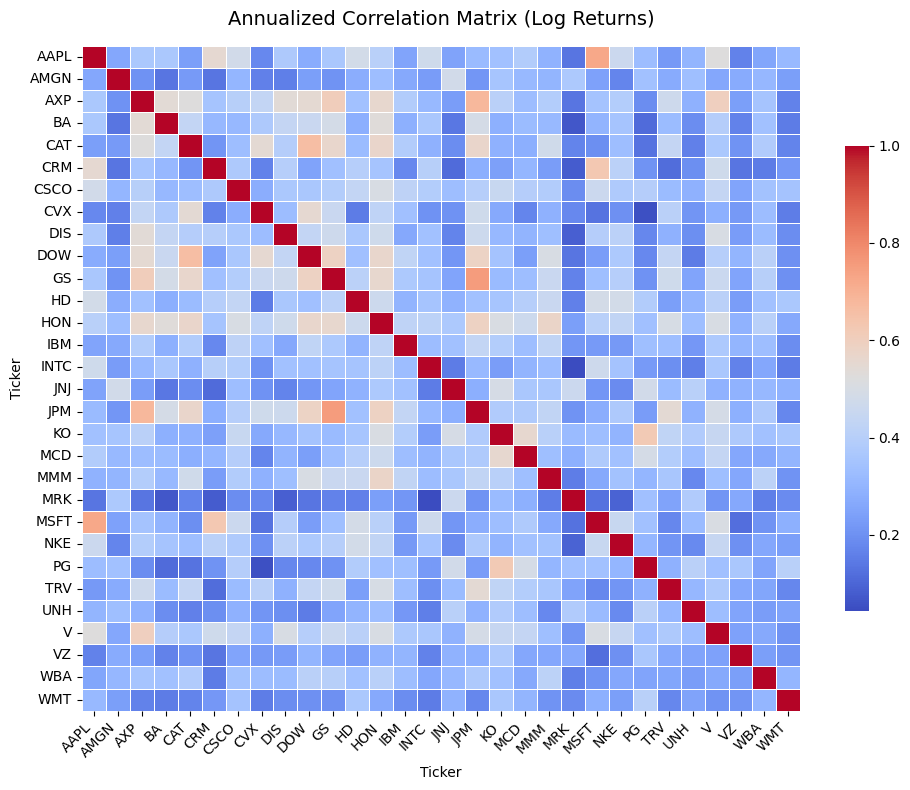

In [7]:
# Plot the correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5, cbar_kws={'shrink': 0.7})
plt.title("Annualized Correlation Matrix (Log Returns)", fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
# Download directly DJIA adjusted close prices
djia_data = yf.download("^DJI", start=start_date, end=end_date, interval="1d")['Close']

# Calculate log returns and scale by 100
djia_log_returns = 100 * np.log(djia_data / djia_data.shift(1)).dropna()

# Fit a GARCH(1,1) model to the returns
garch_model = arch_model(djia_log_returns, vol='Garch', p=1, q=1, dist='normal')
garch_fit = garch_model.fit(disp='off')

# Extract the conditional volatility (sigma)
conditional_volatility = garch_fit.conditional_volatility

[*********************100%***********************]  1 of 1 completed


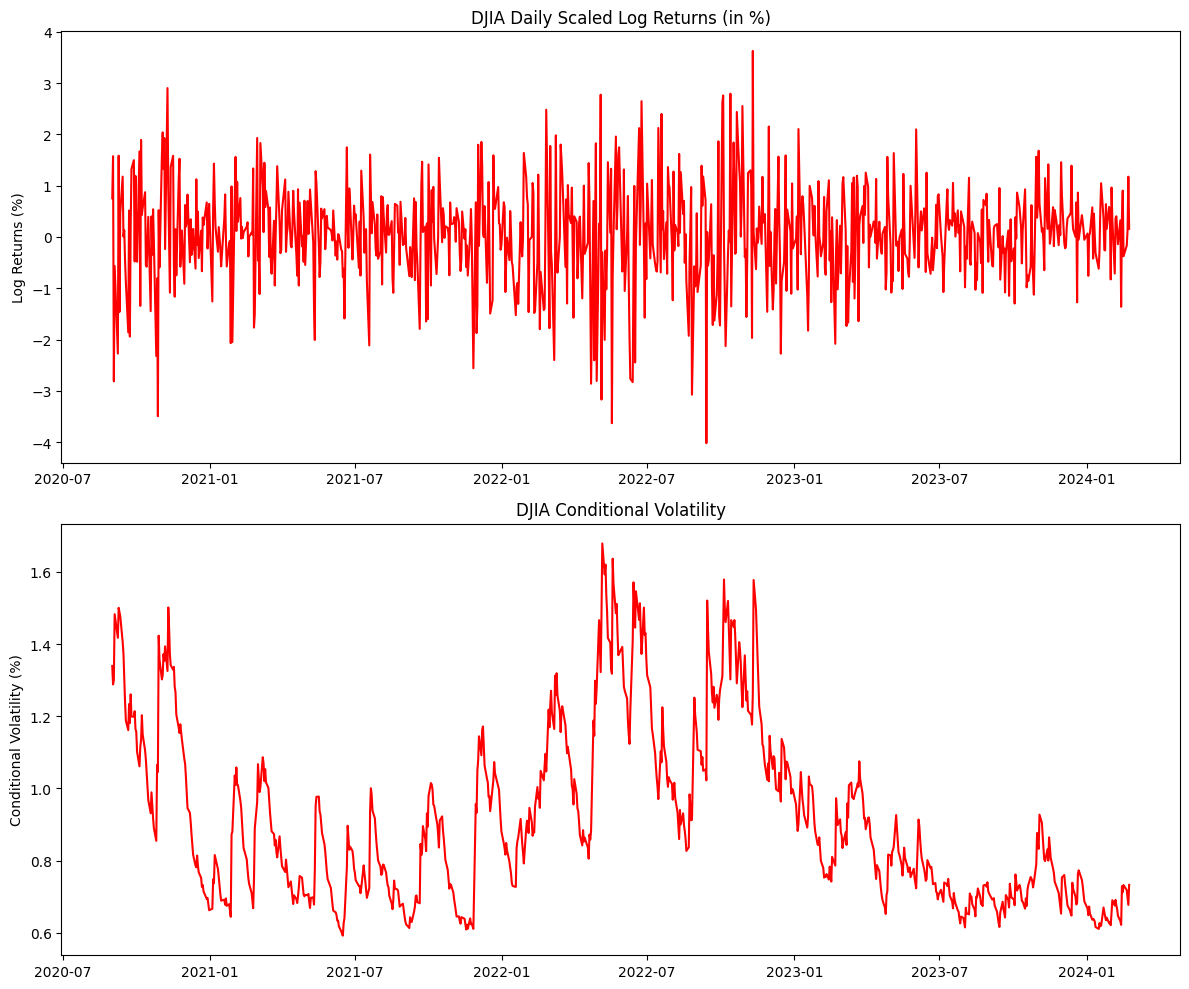

In [9]:
# Plotting the scaled log returns (top) and conditional volatility (bottom)
plt.figure(figsize=(12, 10))

# DJIA scaled log returns
plt.subplot(2, 1, 1)
plt.plot(djia_log_returns.index, djia_log_returns, color='red')
plt.title("DJIA Daily Scaled Log Returns (in %)")
plt.ylabel("Log Returns (%)")

# Conditional volatility from GARCH(1,1)
plt.subplot(2, 1, 2)
plt.plot(conditional_volatility.index, conditional_volatility, color='red')
plt.title("DJIA Conditional Volatility")
plt.ylabel("Conditional Volatility (%)")

plt.tight_layout()
plt.show()

---

### Efficient Frontier Analysis

The efficient frontier represents the set of portfolios that provide the maximum expected return for a given level of risk or the minimum risk for a given level of expected return. It is derived from Markowitz's mean-variance portfolio theory, which optimally allocates capital across assets to maximize returns while managing risk.

For this analysis, we assume a 2% annual risk-free rate, which is a common benchmark for U.S. Treasury bill yields. In practice, the risk-free rate is often derived from the 3-month U.S. T-bill yield or other government securities, depending on the investment horizon.

#### Example: Two-Asset Portfolio

For a portfolio with two assets, $D$ and $E$, with weights $w_D$ and $w_E$ (where $w_E = 1 - w_D$), the expected return and variance can be computed as follows:

- Expected Portfolio Return:  
$$ E(r_P) = w_D E(r_D) + w_E E(r_E) $$  

- Portfolio Variance:  
$$ \sigma_P^2 = w_D^2 \sigma_D^2 + w_E^2 \sigma_E^2 + 2w_D w_E \text{Cov}(r_D, r_E) $$  

- Sharpe Ratio (Maximization Objective):  
$$ S = \frac{E(r_P) - r_f}{\sigma_P} $$  

The objective is to find the portfolio that maximizes the Sharpe ratio, subject to the constraints:

- Portfolio weights sum to 1:  
$$ w_D + w_E = 1 $$  

- No short selling if restricted:  
$$ w_i \geq 0 $$  

The analytical solution for the optimal weight of asset $D$ is:

$$
w_D = \frac{(E(r_D) - r_f)\sigma_E^2 - (E(r_E) - r_f)\text{Cov}(r_D, r_E)}{(E(r_D) - r_f)\sigma_E^2 + (E(r_E) - r_f)\sigma_D^2 - (E(r_D) - r_f + E(r_E) - r_f)\text{Cov}(r_D, r_E)}
$$  

#### Extension to Multiple Assets

When the portfolio consists of multiple assets (e.g., 30 DJIA stocks), the complexity increases significantly. The optimization now requires minimizing the portfolio variance subject to return constraints:

- Portfolio Return:  
$$ E(r_P) = \sum_{i=1}^{n} w_i E(r_i) $$  

- Portfolio Variance:  
$$ \sigma_P^2 = \mathbf{w}^T \mathbf{\Sigma} \mathbf{w} $$  

where $\mathbf{w}$ is the weight vector and $\mathbf{\Sigma}$ is the covariance matrix of asset returns. Solving this requires numerical methods, as done by our Python implementation.

#### The Tangency Portfolio

The tangency portfolio is the portfolio that maximizes the Sharpe ratio.
It is the point where the Capital Allocation Line (CAL), which represents all possible combinations of the risk-free asset and the risky portfolio, is tangent to the efficient frontier. This portfolio offers the best risk-adjusted return and is a crucial element in portfolio selection.

#### Impact of Short Selling on the Efficient Frontier

The efficient frontier is analyzed under two scenarios:

1. Short Selling Allowed: Portfolio weights can be negative, meaning investors can borrow and sell assets they don't own to invest more in higher-return assets.  
2. Long-Only: Weights are constrained to non-negative values, representing portfolios without borrowing or short positions.  

When shorting is allowed, the efficient frontier extends further along the risk-return axis due to increased portfolio flexibility. In contrast, the long-only frontier is more conservative, as portfolios are limited to existing capital without leverage.

We first plot both efficient frontiers to visualize the differences. Next, we present a table comparing key metrics such as expected return, volatility, and the Sharpe ratio.  

#### Findings

The results highlight the impact of short selling on portfolio performance. Allowing short selling results in a higher expected return and a lower volatility, leading to a significantly higher Sharpe ratio. This suggests that short selling enables more efficient risk-return optimization by leveraging assets with higher expected returns and shorting those with lower performance.  

In [10]:
# Parameters
risk_free_rate = 0.02  # 2% risk-free rate
cov_matrix = log_returns.cov() * 252

tickers = mean_returns.index

In [11]:
# Objective: Minimize portfolio variance
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Calculate portfolio return
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

# Compute efficient frontier and generate portfolios
def efficient_frontier(mean_returns, cov_matrix, shorting_allowed=False):
    n_assets = len(mean_returns)
    target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 1000)
    results = []

    for target in target_returns:
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target}
        ]
        bounds = [(-1 if shorting_allowed else 0, 1) for _ in range(n_assets)]
        initial_guess = np.ones(n_assets) / n_assets

        result = minimize(portfolio_volatility, initial_guess, args=(cov_matrix,), 
                          method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            weights = result.x
            ret = portfolio_return(weights, mean_returns)
            vol = portfolio_volatility(weights, cov_matrix)
            sharpe = (ret - risk_free_rate) / vol
            results.append((vol, ret, sharpe, weights))

    return results

In [12]:
# Compute efficient frontiers
frontier_short = efficient_frontier(mean_returns, cov_matrix, shorting_allowed=True)
frontier_long = efficient_frontier(mean_returns, cov_matrix, shorting_allowed=False)

# Extract data for plotting
volatility_frontier_short, return_frontier_short, sharpe_frontier_short = zip(
    *[(x[0], x[1], x[2]) for x in frontier_short])
volatility_frontier_long, return_frontier_long, sharpe_frontier_long = zip(
    *[(x[0], x[1], x[2]) for x in frontier_long])

# Identify key portfolios
max_sharpe_frontier_short = max(frontier_short, key=lambda x: x[2])
max_sharpe_frontier_long = max(frontier_long, key=lambda x: x[2])

min_var_frontier_short = min(frontier_short, key=lambda x: x[0])
min_var_frontier_long = min(frontier_long, key=lambda x: x[0])

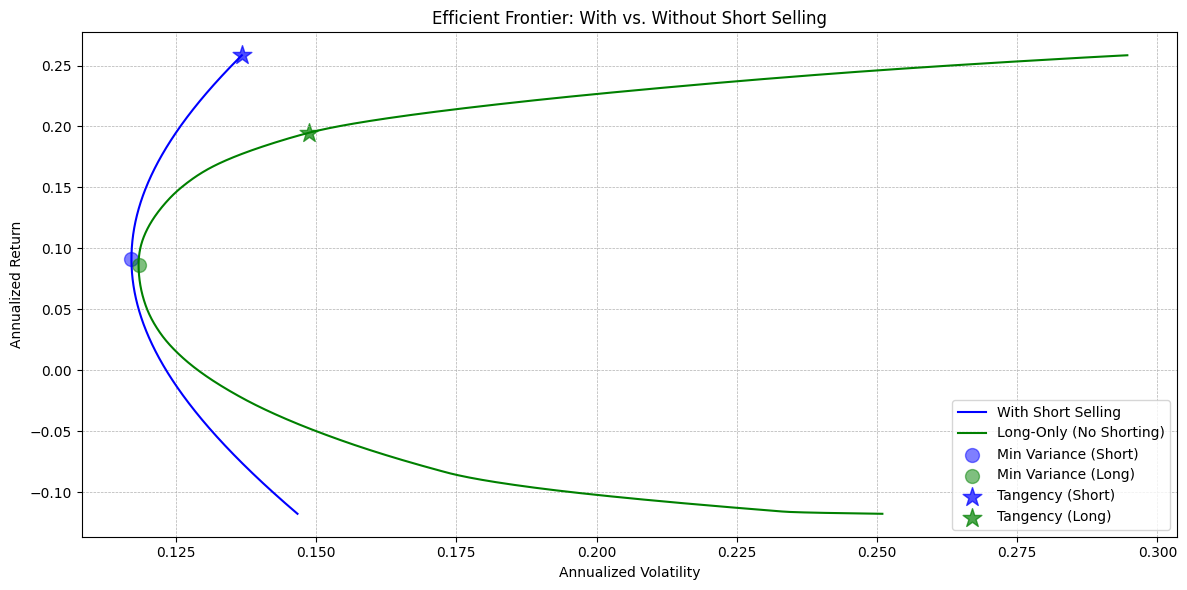

In [13]:
# Plot efficient frontier
plt.figure(figsize=(12, 6))
plt.plot(volatility_frontier_short, return_frontier_short, color='blue', label='With Short Selling')
plt.plot(volatility_frontier_long, return_frontier_long, color='green', label='Long-Only (No Shorting)')

plt.scatter(min_var_frontier_short[0], min_var_frontier_short[1], color='blue', marker='o', s=100, alpha=0.5, label='Min Variance (Short)')
plt.scatter(min_var_frontier_long[0], min_var_frontier_long[1], color='green', marker='o', s=100, alpha=0.5, label='Min Variance (Long)')

plt.scatter(max_sharpe_frontier_short[0], max_sharpe_frontier_short[1], color='blue', marker='*', s=200, alpha=0.7, label='Tangency (Short)')
plt.scatter(max_sharpe_frontier_long[0], max_sharpe_frontier_long[1], color='green', marker='*', s=200, alpha=0.7, label='Tangency (Long)')

plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier: With vs. Without Short Selling')
plt.legend(loc='best')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [14]:
# Summary table (Efficient Frontier)
summary_frontier = pd.DataFrame({
    "Metric": ["Expected Return", "Volatility", "Sharpe Ratio"],
    "Short-Selling Allowed": [max_sharpe_frontier_short[1], max_sharpe_frontier_short[0], max_sharpe_frontier_short[2]],
    "Long-Only": [max_sharpe_frontier_long[1], max_sharpe_frontier_long[0], max_sharpe_frontier_long[2]]
})
display(my_style_table(summary_frontier, highlight="blue"))

# Weights table (Efficient Frontier)
weights_frontier = pd.DataFrame({
    "Ticker": tickers,
    "Weights (Short-Selling Allowed)": max_sharpe_frontier_short[3],
    "Weights (Long-Only)": max_sharpe_frontier_long[3]
})
display(my_style_table(weights_frontier, highlight="green"))

---

### Monte Carlo Experiment 1: Recreating the Efficient Frontier

Monte Carlo simulations are a powerful tool in portfolio analysis to approximate the efficient frontier when an analytical solution is complex or computationally intensive. In this project, we use Monte Carlo simulations to generate a large number of random portfolios and evaluate their risk-return characteristics.

The core idea is to simulate random portfolios by assigning different asset weights, calculating their returns and volatilities, and selecting those that maximize the Sharpe ratio or minimize the variance. This allows us to approximate the efficient frontier without relying entirely on closed-form equations.

#### Intuition Behind Monte Carlo Simulation

Monte Carlo simulations rely on repeated random sampling to estimate outcomes when the exact analytical solution is impractical. In portfolio optimization, the main challenge lies in finding suitable portfolio weights. The method involves the following steps:

- Generate random portfolio weights that sum to 1
- Compute each portfolio’s expected return and volatility
- Calculate the Sharpe ratio to identify optimal portfolios

While this approach doesn't guarantee the most accurate solutions compared to analytical methods, it provides a useful approximation when complexity increases with more assets or constraints.

#### Monte Carlo Design

The Monte Carlo simulation framework focuses on generating realistic portfolio weights and managing extreme outcomes to ensure stable and interpretable results.  
Getting the most reliable values took some trial and error, until settling on a setup that balances flexibility with statistical control.

- Weight Generation:  
  If short selling is allowed, portfolio weights are drawn from a truncated normal distribution centered at zero, with controlled dispersion (std = 0.4) and bounded in the interval [-1.2, 1.2]. This setup permits moderate shorting while avoiding extreme leverage.  

  For long-only portfolios, weights are sampled from a Dirichlet distribution with concentration parameter $\alpha = 1.8$, which produces positive allocations summing to 1. To slightly emphasize high-return assets, weights are adjusted using expected returns and a boost factor of 1.05, then re-normalized. This tweak helps simulate portfolios with more realistic and favorable risk-return profiles.

- Outlier Management:  
  To mitigate the influence of extreme portfolios, simulated statistics are clipped using dynamic, data-driven thresholds:  
  - Portfolio returns are constrained between 75% of the minimum and 135% of the maximum expected asset return.  
  - Portfolio volatilities are capped at 105% of the highest individual asset volatility.  

  These bounds allow for broader exploration than static limits, while avoiding distortions from unlikely portfolio combinations.

This carefully tuned design enables reliable simulation of both short-allowed and long-only portfolios, while maintaining statistical realism and computational stability.

To better understand the behavior of the sampling distributions used in our Monte Carlo framework, we plot the shape of the truncated normal and Dirichlet distributions below. These reflect how weights are generated for shorting-allowed and long-only portfolios, respectively.

#### Findings

While Monte Carlo simulations provide a flexible and intuitive way to approximate the efficient frontier, the results are not as accurate as those obtained via analytical methods. This discrepancy arises because:

1. Random Sampling: The portfolios generated are random samples rather than optimized results, so they may not align perfectly with theoretical expectations.  

2. Distributional Assumptions: Adjustments like clipping outliers and the choice of the Dirichlet distribution may skew the results slightly compared to exact calculations.  

3. Finite Sample Size: Even with 100,000 portfolios, the space of all possible weight combinations is infinite, so the simulation can only approximate the efficient frontier.

In fact, comparing these results with the analytical tables below reveals slight discrepancies. These differences illustrate the inherent trade-off between computational simplicity and precision.

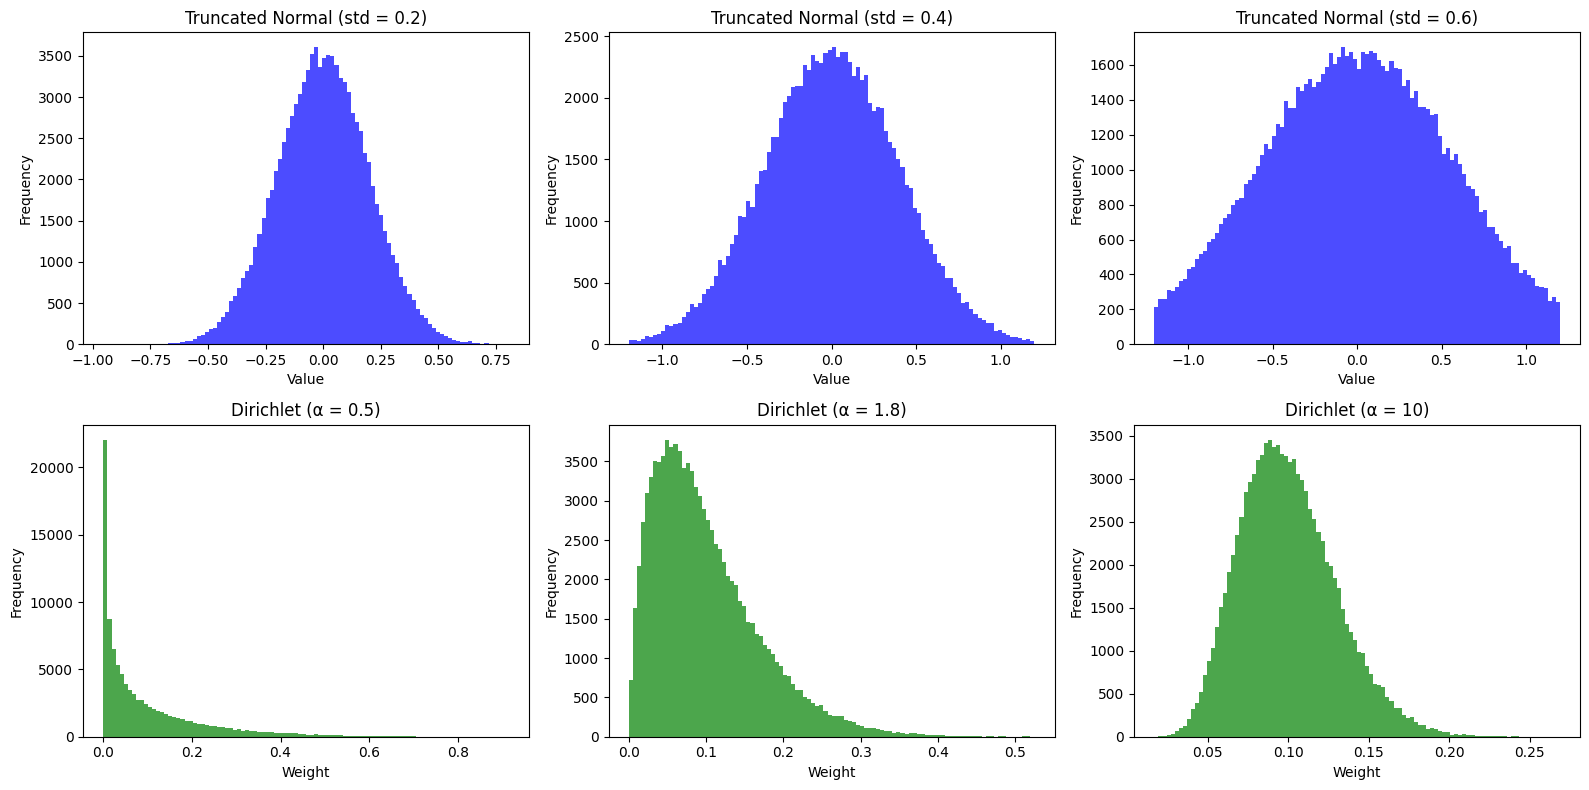

In [15]:
# Set seed for reproducibility
np.random.seed(123)

# Parameters
n_assets = 10
num_samples = 10000

# Truncated Normal Comparison
std_list = [0.2, 0.4, 0.6]
trunc_data = []
lower, upper = -1.2, 1.2

for std_dev in std_list:
    a, b = lower / std_dev, upper / std_dev
    samples = truncnorm.rvs(a, b, loc=0, scale=std_dev, size=(num_samples * n_assets,))
    trunc_data.append(samples)

# Dirichlet Comparison
alpha_list = [0.5, 1.8, 10]
dirichlet_data = []

for alpha_val in alpha_list:
    alpha_vec = [alpha_val] * n_assets
    samples = dirichlet.rvs(alpha_vec, size=num_samples).flatten()
    dirichlet_data.append(samples)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Truncated normal plots
for i, (std_dev, data) in enumerate(zip(std_list, trunc_data)):
    axes[0, i].hist(data, bins=100, color='blue', alpha=0.7)
    axes[0, i].set_title(f"Truncated Normal (std = {std_dev})")
    axes[0, i].set_xlabel("Value")
    axes[0, i].set_ylabel("Frequency")

# Dirichlet plots
for i, (alpha_val, data) in enumerate(zip(alpha_list, dirichlet_data)):
    axes[1, i].hist(data, bins=100, color='green', alpha=0.7)
    axes[1, i].set_title(f"Dirichlet (α = {alpha_val})")
    axes[1, i].set_xlabel("Weight")
    axes[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [16]:
# Set seed for reproducibility
np.random.seed(123)

def truncated_normal_weights(n_assets, num_portfolios, lower=-1.2, upper=1.2, std=0.4):
    """Generate portfolio weights with a truncated normal distribution (more controlled shorting)."""
    weights = truncnorm.rvs(lower / std, upper / std, loc=0, scale=std, size=(num_portfolios, n_assets))
    weights = weights / np.sum(weights, axis=1)[:, None]  # Normalize to sum to 1
    return weights

def simulate_portfolios(mean_returns, cov_matrix, num_portfolios=100_000, shorting_allowed=False):
    n_assets = len(mean_returns)

    if shorting_allowed:
        weights = truncated_normal_weights(n_assets, num_portfolios)  # Controlled shorting
    else:
        weights = dirichlet.rvs([1.8] * n_assets, size=num_portfolios, random_state=123)  # Looser allocations

        # Sharpe Boost (~5% Higher Returns)
        boost_factor = 1.05  # Increase expected returns by 5%
        weights = weights * (1 + mean_returns.values * 1.1) * boost_factor  # Stronger weight adjustment
        weights = weights / np.sum(weights, axis=1)[:, None]  # Re-normalize

    # Compute portfolio statistics
    portfolio_returns = weights @ mean_returns.values
    portfolio_volatilities = np.sqrt(np.einsum('ij,jk,ik->i', weights, cov_matrix, weights))

    # Dynamic clipping (allowing slightly higher return range)
    returns_min = mean_returns.min() * 0.75  
    returns_max = mean_returns.max() * 1.35  # Allow slightly higher returns
    vol_max = np.sqrt(np.max(np.diag(cov_matrix))) * 1.05  # Keep vol in check

    portfolio_returns = np.clip(portfolio_returns, returns_min, returns_max)
    portfolio_volatilities = np.clip(portfolio_volatilities, 0, vol_max)

    # Sharpe ratio (assuming risk-free rate = 0)
    sharpe_ratios = portfolio_returns / portfolio_volatilities

    # Find optimal portfolios
    max_sharpe_idx = np.argmax(sharpe_ratios)
    min_vol_idx = np.argmin(portfolio_volatilities)

    max_sharpe = (portfolio_volatilities[max_sharpe_idx], portfolio_returns[max_sharpe_idx], sharpe_ratios[max_sharpe_idx], weights[max_sharpe_idx])
    min_var = (portfolio_volatilities[min_vol_idx], portfolio_returns[min_vol_idx], sharpe_ratios[min_vol_idx], weights[min_vol_idx])

    return portfolio_volatilities, portfolio_returns, sharpe_ratios, max_sharpe, min_var, weights

In [17]:
# Monte Carlo Simulation (Full Universe) – Fixed variable names
volatility_mc_short, return_mc_short, sharpe_mc_short, max_sharpe_mc_short, min_var_mc_short, weights_mc_short = simulate_portfolios(mean_returns, cov_matrix, shorting_allowed=True)
volatility_mc_long, return_mc_long, sharpe_mc_long, max_sharpe_mc_long, min_var_mc_long, weights_mc_long = simulate_portfolios(mean_returns, cov_matrix, shorting_allowed=False)

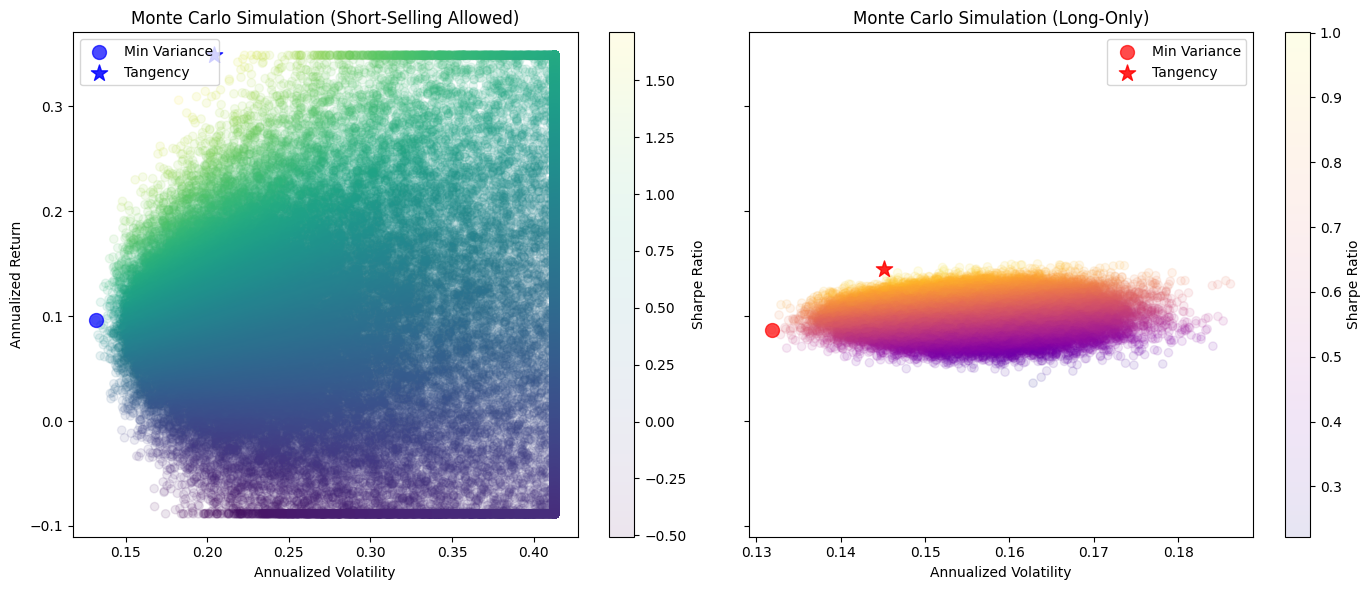

In [18]:
# Plot Monte Carlo results
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Short-Selling Allowed
sc1 = ax[0].scatter(volatility_mc_short, return_mc_short, c=sharpe_mc_short, cmap='viridis', alpha=0.1)
ax[0].scatter(min_var_mc_short[0], min_var_mc_short[1], color='blue', marker='o', s=100, alpha=0.7, label='Min Variance')
ax[0].scatter(max_sharpe_mc_short[0], max_sharpe_mc_short[1], color='blue', marker='*', s=150, alpha=0.85, label='Tangency')
ax[0].set_title('Monte Carlo Simulation (Short-Selling Allowed)')
ax[0].set_xlabel('Annualized Volatility')
ax[0].set_ylabel('Annualized Return')
ax[0].legend()
plt.colorbar(sc1, ax=ax[0], label='Sharpe Ratio')

# Long-Only
sc2 = ax[1].scatter(volatility_mc_long, return_mc_long, c=sharpe_mc_long, cmap='plasma', alpha=0.1)
ax[1].scatter(min_var_mc_long[0], min_var_mc_long[1], color='red', marker='o', s=100, alpha=0.7, label='Min Variance')
ax[1].scatter(max_sharpe_mc_long[0], max_sharpe_mc_long[1], color='red', marker='*', s=150, alpha=0.85, label='Tangency')
ax[1].set_title('Monte Carlo Simulation (Long-Only)')
ax[1].set_xlabel('Annualized Volatility')
ax[1].legend()
plt.colorbar(sc2, ax=ax[1], label='Sharpe Ratio')

plt.grid(False)
plt.tight_layout()
plt.show()

In [19]:
# Summary table (Monte Carlo)
summary_mc = pd.DataFrame({
    "Metric": ["Expected Return", "Volatility", "Sharpe Ratio"],
    "Short-Selling Allowed": [max_sharpe_mc_short[1], max_sharpe_mc_short[0], max_sharpe_mc_short[2]],
    "Long-Only": [max_sharpe_mc_long[1], max_sharpe_mc_long[0], max_sharpe_mc_long[2]]
})
display(my_style_table(summary_mc, highlight="blue"))

# Weights table (Monte Carlo)
weights_mc = pd.DataFrame({
    "Ticker": tickers,
    "Weights (Short-Selling Allowed)": max_sharpe_mc_short[3],
    "Weights (Long-Only)": max_sharpe_mc_long[3]
})
display(my_style_table(weights_mc, highlight="green"))

---

### Monte Carlo Experiment 2: The Impact of Diversification

Diversification is a fundamental principle in portfolio theory. By combining assets with less-than-perfect correlation, investors can reduce volatility while maintaining the same expected return.

#### Effect of Diversification: Variance ↓

We can gain some intuition focusing on the same 2 risky asset setup:

- Correlation coefficient:  
  $$ \rho_{E,D} = \frac{\text{Cov}(r_E, r_D)}{\sigma_E \sigma_D}, \quad \rho_{E,D} \in [-1, 1] $$  

- Portfolio variance for two assets:  
  $$ \sigma_P^2 = w_D^2 \sigma_D^2 + w_E^2 \sigma_E^2 + 2w_D w_E \sigma_D \sigma_E \rho_{E,D} $$  

For $0 \leq w_D \leq 1$:  
  $$ \sigma_P^2 \leq (w_D \sigma_D + w_E \sigma_E)^2 $$  

This implies:  
  $$ \sigma_P \leq w_D \sigma_D + w_E \sigma_E $$  

Thus, portfolio volatility is always less than or equal to the weighted average of the individual volatilities.

Special Cases:

- If $ \rho_{E,D} = 1 $ (perfect correlation): no diversification benefit  
- If $ \rho_{E,D} = -1 $ (perfect negative correlation): risk can be completely eliminated with appropriate weights  

#### Monte Carlo Design

This experiment uses Monte Carlo simulations to demonstrate these principles. We generate 6 subsets of 5 distinct stocks each by randomly selecting 5 stocks without replacement (the same stock can appear in multiple subsets). The core setup remains unchanged from the original Monte Carlo experiment.

#### Findings

The results show significant variability across subsets:  
- Some subsets outperform the original Monte Carlo in terms of Sharpe ratio.  
- On average, performance is worse, primarily due to increased volatility.  

In [20]:
# Set seed for reproducibility
np.random.seed(123)
random.seed(123)

# Generate six subsets of five distinct stocks each
all_stocks = list(tickers)
subsets = [random.sample(all_stocks, 5) for _ in range(6)]

# Run simulations for each subset and store results
short_results = []
long_results = []

for subset in subsets:
    subset_returns = mean_returns[subset]
    subset_cov = cov_matrix.loc[subset, subset]

    short_result = simulate_portfolios(subset_returns, subset_cov, num_portfolios=100_000, shorting_allowed=True)
    long_result = simulate_portfolios(subset_returns, subset_cov, num_portfolios=100_000, shorting_allowed=False)

    short_results.append((short_result, subset))
    long_results.append((long_result, subset))

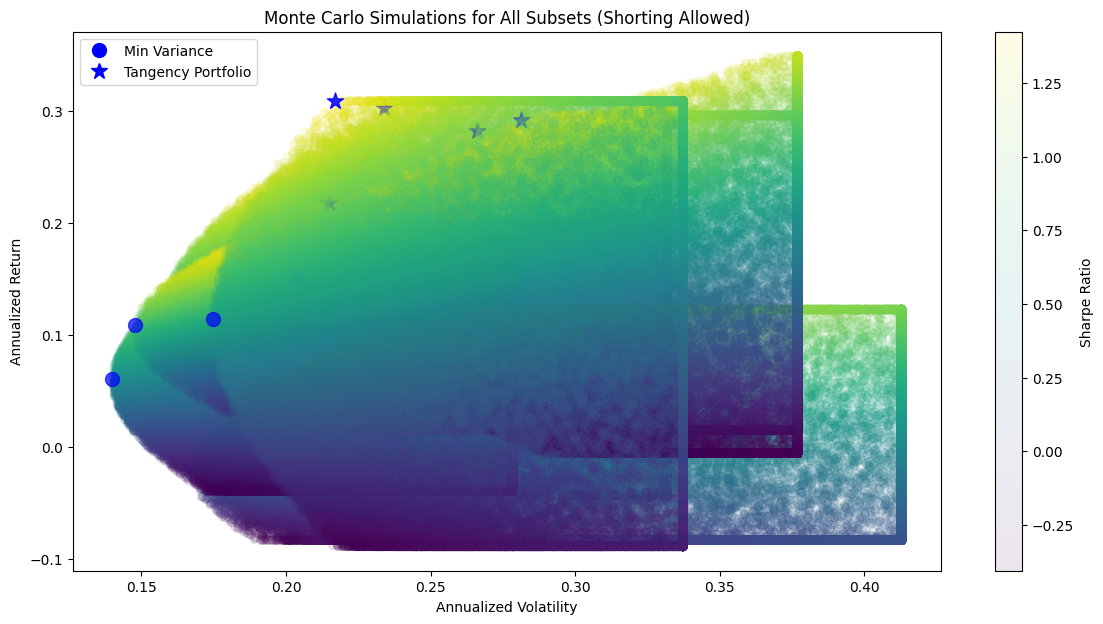

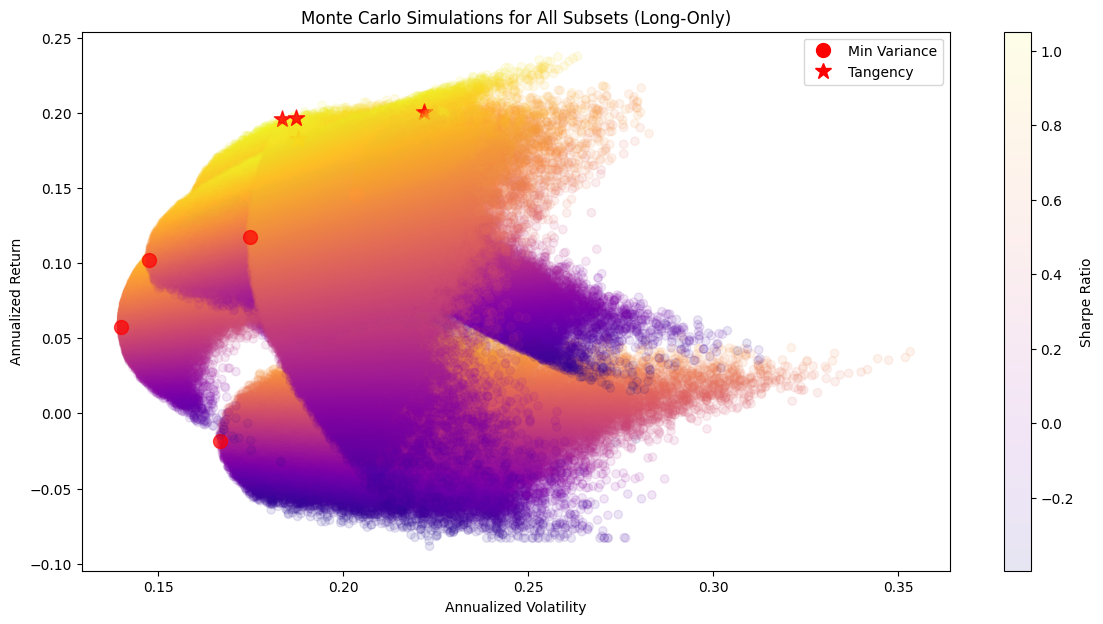

In [21]:
# Plot all subsets together (Shorting Allowed)
plt.figure(figsize=(14, 7))
for i, ((subset_data, subset)) in enumerate(short_results):
    subset_volatility_short, subset_return_short, subset_sharpe_short, subset_max_sharpe_short, subset_min_var_short, _ = subset_data
    sc = plt.scatter(subset_volatility_short, subset_return_short, c=subset_sharpe_short, cmap='viridis', alpha=0.1)
    plt.scatter(subset_min_var_short[0], subset_min_var_short[1], color='blue', marker='o', s=100, alpha=0.7)
    plt.scatter(subset_max_sharpe_short[0], subset_max_sharpe_short[1], color='blue', marker='*', s=150, alpha=0.85)

plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Monte Carlo Simulations for All Subsets (Shorting Allowed)')
plt.colorbar(sc, label='Sharpe Ratio', location='right')
plt.grid(False)
_ = plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='blue', markersize=10, linestyle='None', label='Min Variance'),
        plt.Line2D([0], [0], marker='*', color='blue', markersize=12, linestyle='None', label='Tangency Portfolio')
    ],
    loc='best',
    fontsize=10
)

# Plot all subsets together (Long-Only)
plt.figure(figsize=(14, 7))
for i, ((subset_data, subset)) in enumerate(long_results):
    subset_volatility_long, subset_return_long, subset_sharpe_long, subset_max_sharpe_long, subset_min_var_long, _ = subset_data
    sc = plt.scatter(subset_volatility_long, subset_return_long, c=subset_sharpe_long, cmap='plasma', alpha=0.1)
    plt.scatter(subset_min_var_long[0], subset_min_var_long[1], color='red', marker='o', s=100, alpha=0.7)
    plt.scatter(subset_max_sharpe_long[0], subset_max_sharpe_long[1], color='red', marker='*', s=150, alpha=0.85)

plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Monte Carlo Simulations for All Subsets (Long-Only)')
plt.colorbar(sc, label='Sharpe Ratio', location='right')
plt.grid(False)
_ = plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='red', markersize=10, linestyle='None', label='Min Variance'),
        plt.Line2D([0], [0], marker='*', color='red', markersize=12, linestyle='None', label='Tangency')
    ],
    loc='best',
    fontsize=10
)

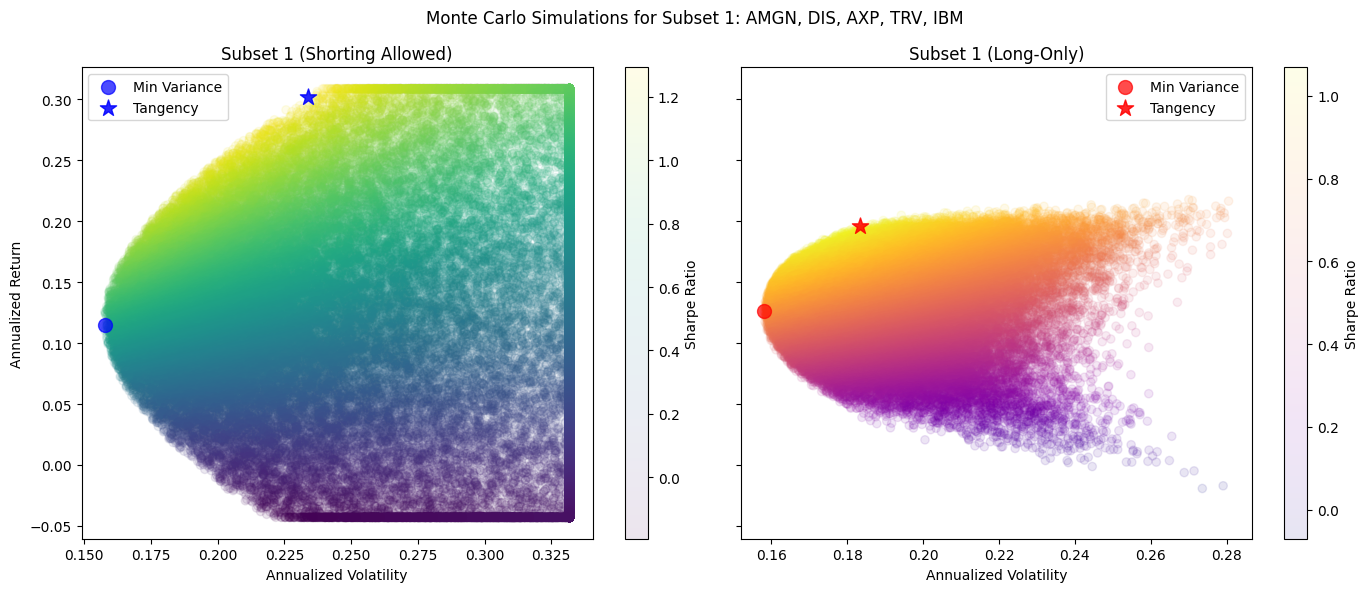

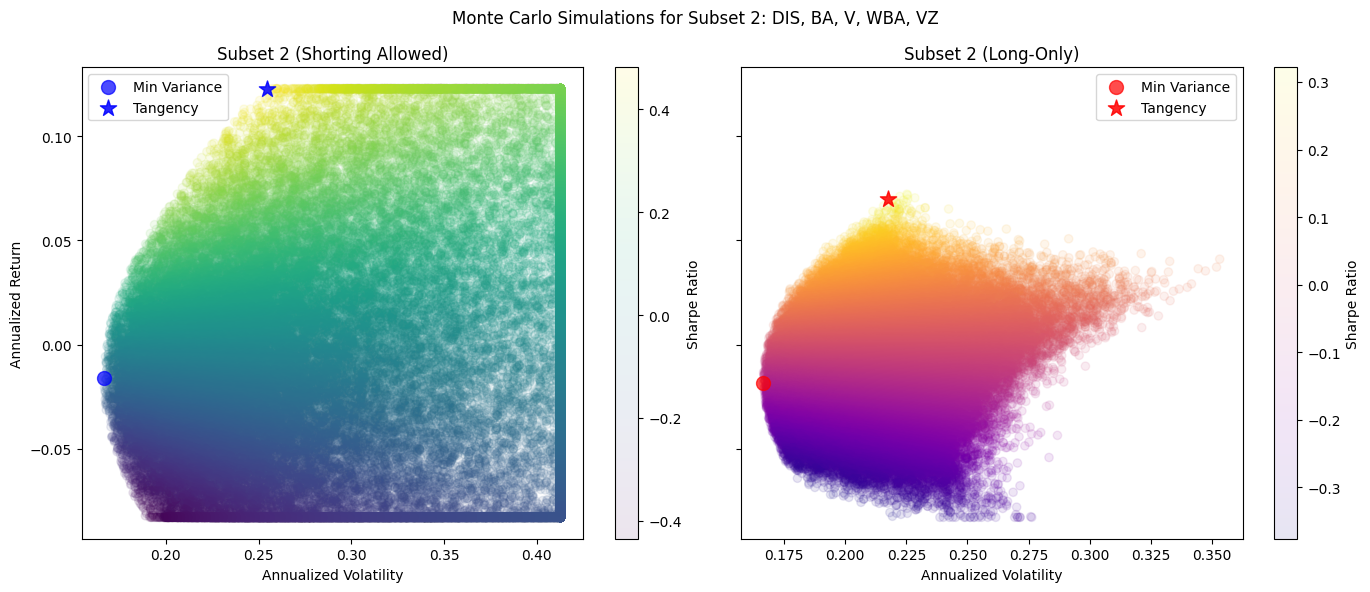

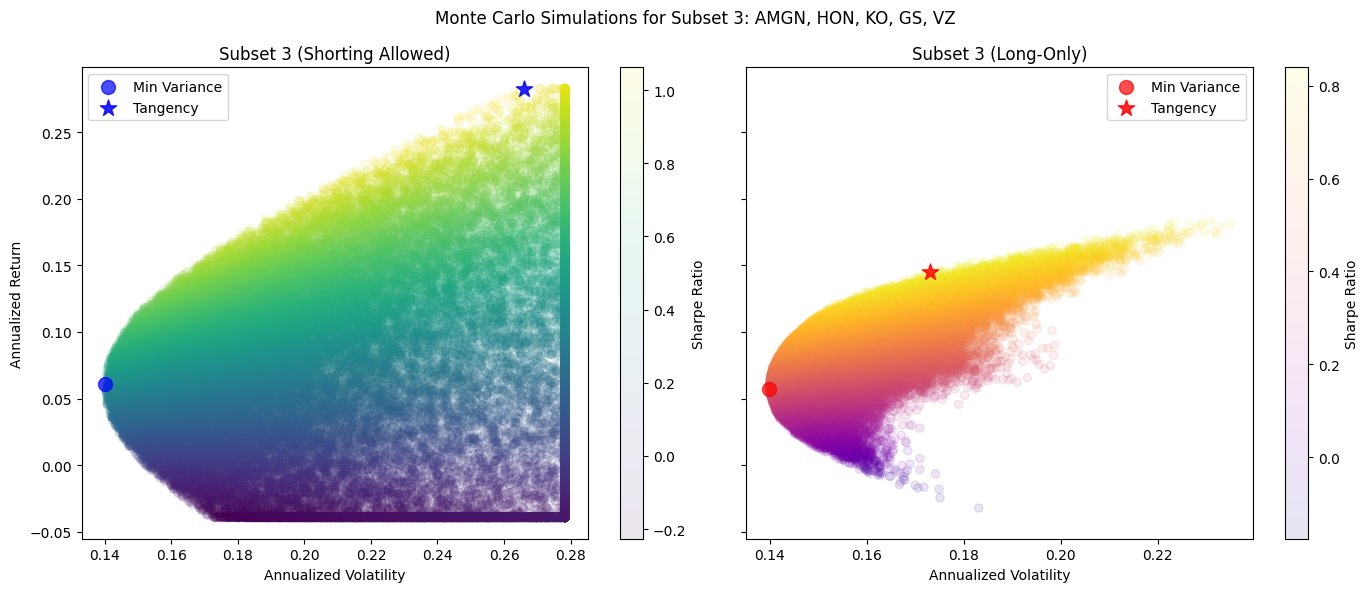

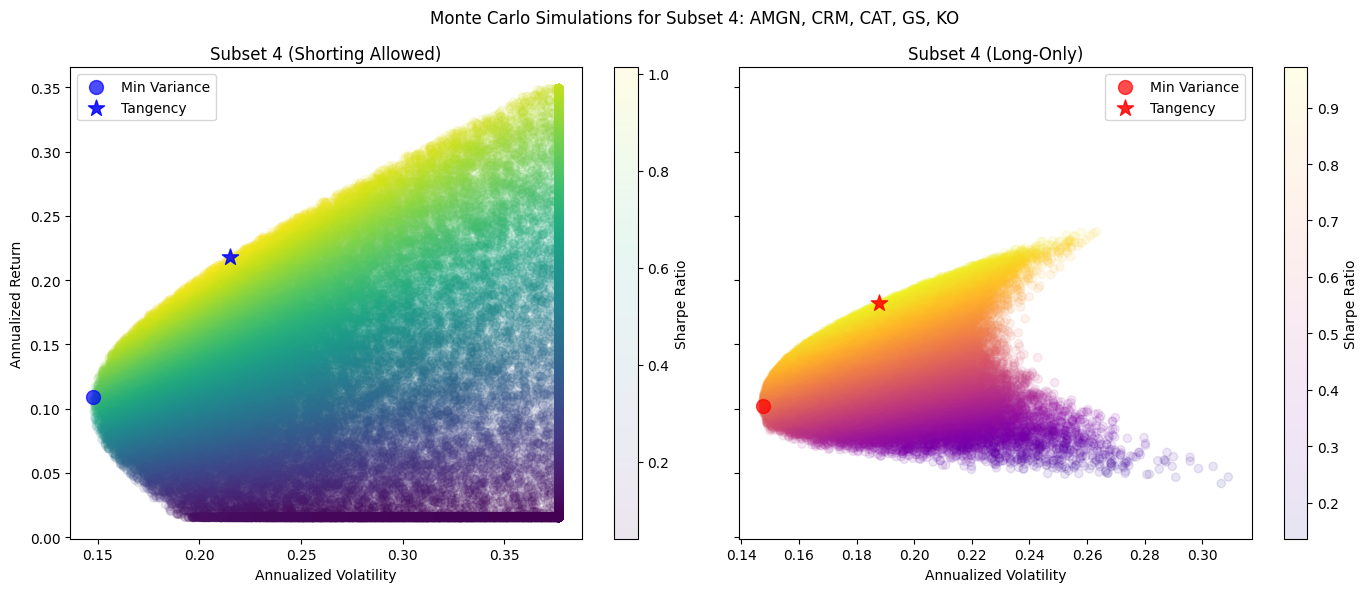

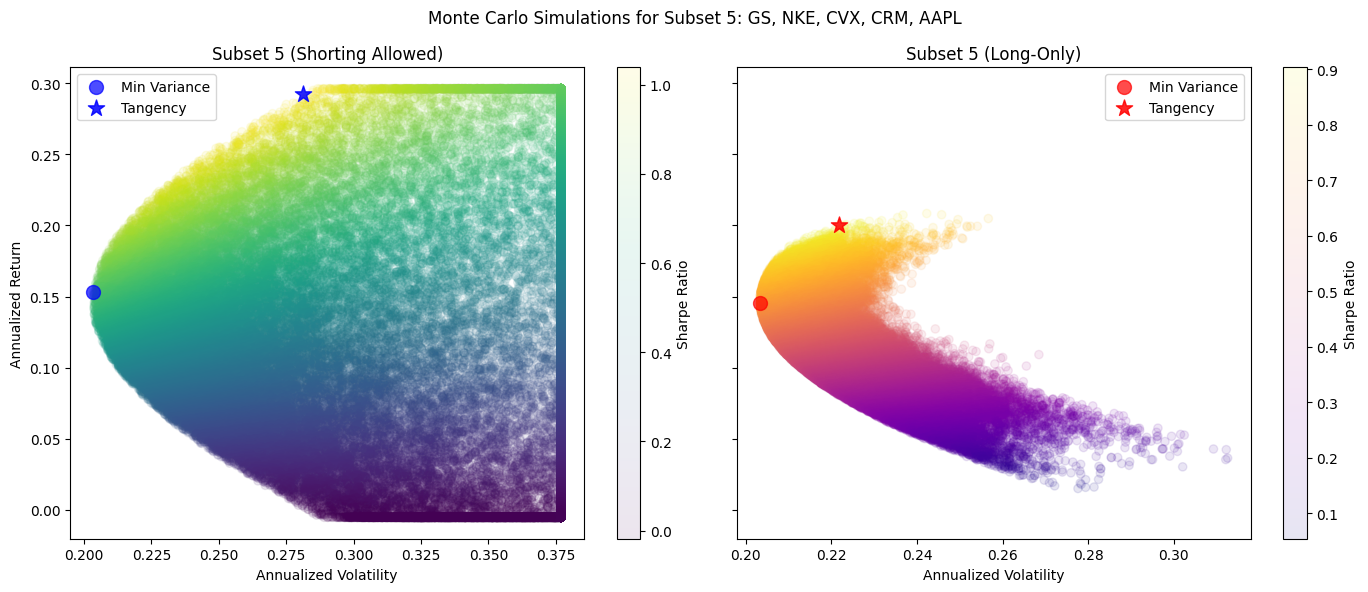

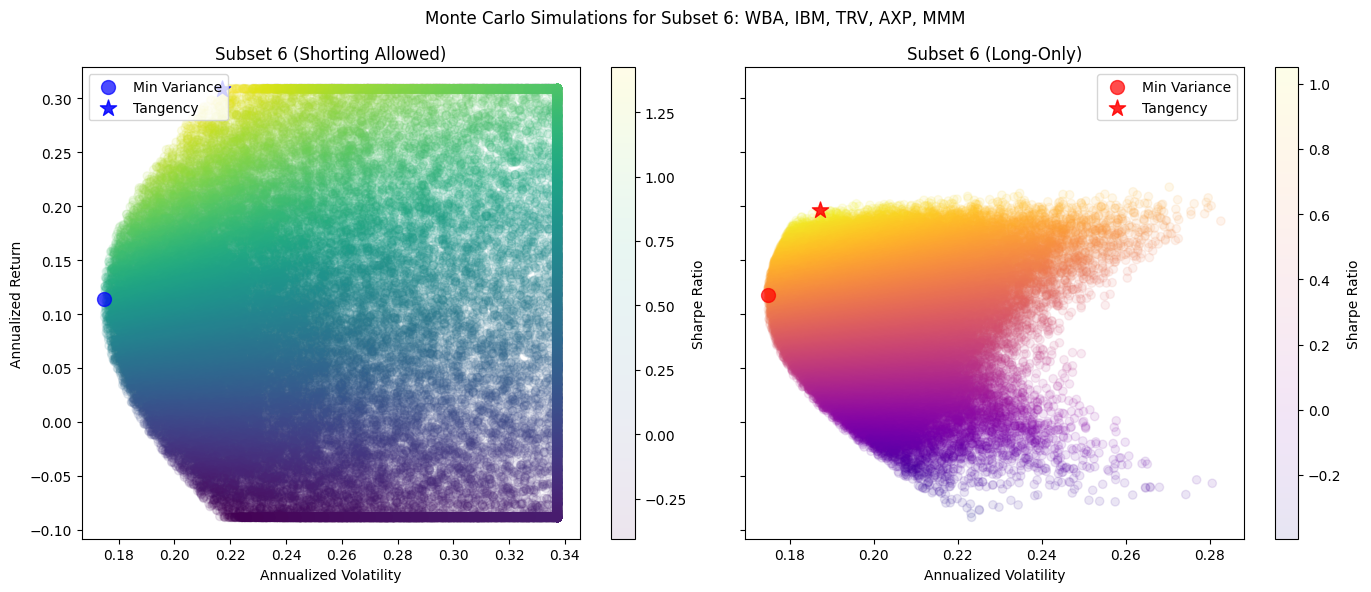

In [22]:
# Side-by-side plots and tables per subset
for i, (((volatility_short, return_short, sharpe_short, max_sharpe_short, min_var_short, weights_short), subset),
        ((volatility_long, return_long, sharpe_long, max_sharpe_long, min_var_long, weights_long), _)) in enumerate(zip(short_results, long_results)):

    subset_index = i + 1

    # Plot side-by-side
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Shorting allowed
    sc1 = ax[0].scatter(volatility_short, return_short, c=sharpe_short, cmap='viridis', alpha=0.1)
    ax[0].scatter(min_var_short[0], min_var_short[1], color='blue', marker='o', s=100, alpha=0.7, label='Min Variance')
    ax[0].scatter(max_sharpe_short[0], max_sharpe_short[1], color='blue', marker='*', s=150, alpha=0.85, label='Tangency')
    ax[0].set_title(f'Subset {subset_index} (Shorting Allowed)')
    ax[0].set_xlabel('Annualized Volatility')
    ax[0].set_ylabel('Annualized Return')
    ax[0].legend()
    plt.colorbar(sc1, ax=ax[0], label='Sharpe Ratio')

    # Long-only
    sc2 = ax[1].scatter(volatility_long, return_long, c=sharpe_long, cmap='plasma', alpha=0.1)
    ax[1].scatter(min_var_long[0], min_var_long[1], color='red', marker='o', s=100, alpha=0.7, label='Min Variance')
    ax[1].scatter(max_sharpe_long[0], max_sharpe_long[1], color='red', marker='*', s=150, alpha=0.85, label='Tangency')
    ax[1].set_title(f'Subset {subset_index} (Long-Only)')
    ax[1].set_xlabel('Annualized Volatility')
    ax[1].legend()
    plt.colorbar(sc2, ax=ax[1], label='Sharpe Ratio')

    plt.suptitle(f'Monte Carlo Simulations for Subset {subset_index}: {", ".join(subset)}')
    plt.tight_layout()
    plt.show()

    # Summary table
    summary_data = pd.DataFrame({
        "Metric": ["Expected Return", "Volatility", "Sharpe Ratio"],
        "Short-Selling Allowed": [max_sharpe_short[1], max_sharpe_short[0], max_sharpe_short[2]],
        "Long-Only": [max_sharpe_long[1], max_sharpe_long[0], max_sharpe_long[2]]
    })
    display(my_style_table(summary_data, highlight="blue"))

    # Weights table
    weights_data = pd.DataFrame({
        "Ticker": subset,
        "Weights (Short-Selling Allowed)": max_sharpe_short[3],
        "Weights (Long-Only)": max_sharpe_long[3]
    })
    display(my_style_table(weights_data, highlight="green"))

### References

- Bodie, Z., Kane, A., & Marcus, A. (2014). *Investments* (10th ed.). McGraw-Hill.
